In [1]:
# Cell 2: imports
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Optional: if running in Colab and data is on Drive, uncomment and mount:
# from google.colab import drive
# drive.mount('/content/drive')


In [2]:
# Cell 3: dataset file paths - update if needed
X_path = '/content/drive/MyDrive/Dataset/LDC_NS_2D/128x128/skelneton_lid_driven_cavity_X.npz'
Y_path = '/content/drive/MyDrive/Dataset/LDC_NS_2D/128x128/skelneton_lid_driven_cavity_Y.npz'

# load files (this will raise if paths are wrong)
X_file = np.load(X_path)
Y_file = np.load(Y_path)

print("Keys in X.npz:", X_file.files)
print("Keys in Y.npz:", Y_file.files)

# Main arrays are usually stored under 'data' as in your original file
X = X_file['data']  # expect shape (N, C, H, W)
Y = Y_file['data']  # expect shape (N, C, H, W)

print("X.shape:", X.shape, "dtype:", X.dtype)
print("Y.shape:", Y.shape, "dtype:", Y.dtype)


Keys in X.npz: ['data']
Keys in Y.npz: ['data']
X.shape: (1000, 3, 128, 128) dtype: float64
Y.shape: (1000, 4, 128, 128) dtype: float64


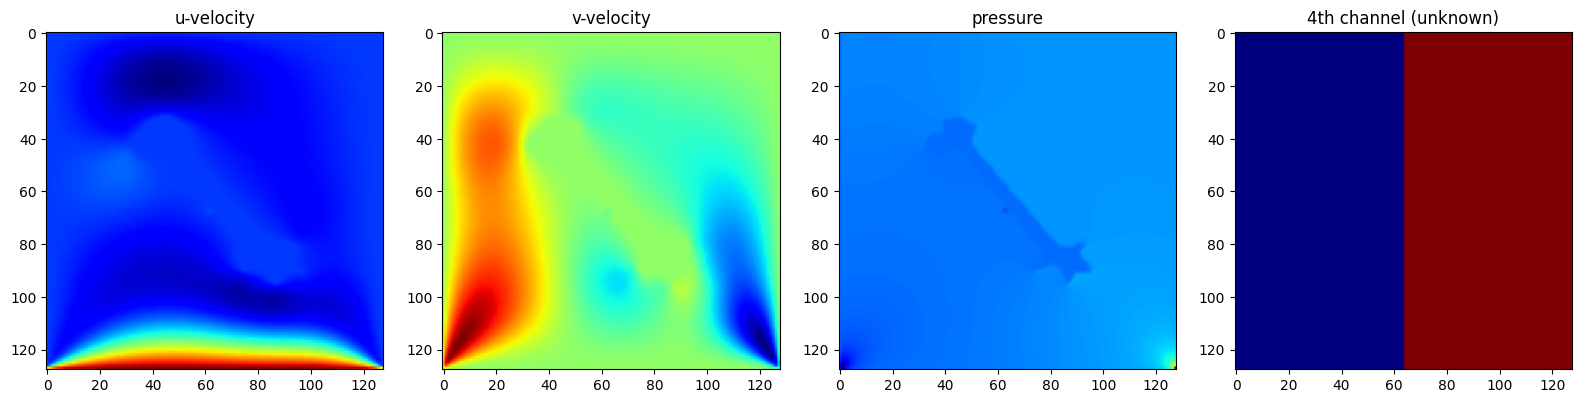

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# pick any sample
idx = 0

# extract all 4 channels
u = Y[idx, 0]
v = Y[idx, 1]
p = Y[idx, 2]
ch4 = Y[idx, 3]

# visualize
fig, axs = plt.subplots(1, 4, figsize=(16,4))

axs[0].imshow(u, cmap='jet')
axs[0].set_title("u-velocity")

axs[1].imshow(v, cmap='jet')
axs[1].set_title("v-velocity")

axs[2].imshow(p, cmap='jet')
axs[2].set_title("pressure")

axs[3].imshow(ch4, cmap='jet')
axs[3].set_title("4th channel (unknown)")

plt.tight_layout()
plt.show()


In [4]:
print("4th channel stats:")
print("min:", Y[:,3].min())
print("max:", Y[:,3].max())
print("mean:", Y[:,3].mean())
print("std:", Y[:,3].std())


4th channel stats:
min: -5.8896309777
max: 1.4871008158386
mean: -0.326581787826835
std: 0.6663058179995365


In [17]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.optim import AdamW
import torch.nn.functional as F

# Load your LDC dataset
X_path = '/content/drive/MyDrive/Dataset/LDC_NS_2D/128x128/skelneton_lid_driven_cavity_X.npz'
Y_path = '/content/drive/MyDrive/Dataset/LDC_NS_2D/128x128/skelneton_lid_driven_cavity_Y.npz'

X_file = np.load(X_path)
Y_file = np.load(Y_path)

X = X_file['data'].astype(np.float32)  # (N, 3, 128, 128)
Y = Y_file['data'].astype(np.float32)  # (N, 4, 128, 128)

print("X shape:", X.shape, "Y shape:", Y.shape)


X shape: (1000, 3, 128, 128) Y shape: (1000, 4, 128, 128)


In [18]:
class LDCDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.Y[idx])

# Split into train/test (80/20)
n_samples = X.shape[0]
n_train = int(0.8 * n_samples)

train_dataset = LDCDataset(X[:n_train], Y[:n_train])
test_dataset  = LDCDataset(X[n_train:], Y[n_train:])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [19]:
# Activation with up/downsampling
class CNO_LReLu(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.act = nn.LeakyReLU()

    def forward(self, x):
        x = F.interpolate(x, size=(2*self.in_size, 2*self.in_size), mode="bicubic", antialias=True)
        x = self.act(x)
        x = F.interpolate(x, size=(self.out_size, self.out_size), mode="bicubic", antialias=True)
        return x

# CNO Block
class CNOBlock(nn.Module):
    def __init__(self, in_channels, out_channels, in_size, out_size, use_bn=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.act = CNO_LReLu(in_size, out_size)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, channels, size, use_bn=True):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels) if use_bn else nn.Identity()
        self.bn2 = nn.BatchNorm2d(channels) if use_bn else nn.Identity()
        self.act = CNO_LReLu(size, size)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return x + out

class ResNet(nn.Module):
    def __init__(self, channels, size, num_blocks, use_bn=True):
        super().__init__()
        self.blocks = nn.Sequential(*[ResidualBlock(channels, size, use_bn) for _ in range(num_blocks)])
    def forward(self, x):
        return self.blocks(x)


In [22]:
class CNO2d(nn.Module):
    def __init__(self, in_dim, out_dim, size, N_layers=4, N_res=4, N_res_neck=4, channel_multiplier=16, use_bn=True):
        super().__init__()
        self.N_layers = N_layers
        self.lift_dim = channel_multiplier // 2
        self.in_dim = in_dim
        self.out_dim = out_dim

        # Lift
        self.lift = CNOBlock(in_dim, self.lift_dim, size, size, use_bn=False)

        # Encoder features (channels)
        # self.encoder_features: [lift_dim, C_0, C_1, ..., C_{N_layers-1}] where C_k = 2^k * channel_multiplier
        self.encoder_features = [self.lift_dim] + [2**i * channel_multiplier for i in range(N_layers)]
        # Add the neck feature size (output of the last encoder block)
        # For N_layers=4, cm=16, this list becomes [8, 16, 32, 64, 128]
        self.encoder_features.append(2**(N_layers-1) * channel_multiplier * 2) # This is effectively encoder_features[N_layers] which was missing the last item

        # Encoder sizes (spatial dimensions)
        # For size=128, N_layers=4, this list becomes [128, 64, 32, 16, 8]
        self.encoder_sizes = [size // 2**i for i in range(N_layers + 1)]

        # Encoder
        self.encoder = nn.ModuleList([CNOBlock(self.encoder_features[i], self.encoder_features[i+1],
                                               self.encoder_sizes[i], self.encoder_sizes[i+1], use_bn)
                                      for i in range(N_layers)])

        # ResNets in encoder path
        self.res_nets = nn.ModuleList([ResNet(self.encoder_features[i], self.encoder_sizes[i], N_res, use_bn)
                                       for i in range(N_layers)])
        self.res_net_neck = ResNet(self.encoder_features[N_layers], self.encoder_sizes[N_layers], N_res_neck, use_bn)


        # --- Decoder specific channel and size definitions ---
        decoder_input_channels = []
        decoder_output_channels = []
        decoder_spatial_sizes_in = []
        decoder_spatial_sizes_out = []

        # First decoder block (i=0) takes input from the neck
        # Input channels: output of res_net_neck = self.encoder_features[N_layers] (e.g. 128)
        # Output channels: should match the skip connection it will be combined with in the next stage
        #                  which is self.encoder_features[N_layers - 1] (e.g. 64)
        decoder_input_channels.append(self.encoder_features[N_layers])
        decoder_output_channels.append(self.encoder_features[N_layers - 1])
        decoder_spatial_sizes_in.append(self.encoder_sizes[N_layers]) # e.g., 8
        decoder_spatial_sizes_out.append(self.encoder_sizes[N_layers - 1]) # e.g., 16

        # Subsequent decoder blocks (i=1 to N_layers-1)
        for i in range(1, N_layers):
            # Input channels = (output of previous decoder block) + (channels from skip connection)
            # The skip connection comes from encoder_features[N_layers - i]
            # The output of the previous decoder block is decoder_output_channels[i-1]
            input_ch = decoder_output_channels[i-1] + self.encoder_features[N_layers - i]
            decoder_input_channels.append(input_ch)
            decoder_output_channels.append(self.encoder_features[N_layers - i - 1])

            decoder_spatial_sizes_in.append(self.encoder_sizes[N_layers - i]) # e.g., 16, 32, 64
            decoder_spatial_sizes_out.append(self.encoder_sizes[N_layers - i - 1]) # e.g., 32, 64, 128

        self.decoder = nn.ModuleList([CNOBlock(decoder_input_channels[i], decoder_output_channels[i],
                                               decoder_spatial_sizes_in[i], decoder_spatial_sizes_out[i], use_bn)
                                      for i in range(N_layers)])

        # Projection layer
        # Input to project is x (output of last decoder block) concatenated with skip[0]
        # Channels: decoder_output_channels[-1] + self.encoder_features[0]
        self.project = nn.Conv2d(decoder_output_channels[-1] + self.encoder_features[0], out_dim, 3, padding=1)

    def forward(self, x):
        x = self.lift(x)
        skip = []
        # Encoder
        for i in range(self.N_layers):
            y = self.res_nets[i](x)
            skip.append(y)
            x = self.encoder[i](x)
        x = self.res_net_neck(x)

        # Decoder
        for i in range(self.N_layers):
            if i > 0:
                # x is output of decoder[i-1]
                # skip[self.N_layers - i] retrieves the correct skip connection
                # For N_layers=4: i=1 -> skip[3], i=2 -> skip[2], i=3 -> skip[1]
                x = torch.cat((x, skip[self.N_layers - i]), dim=1)
            x = self.decoder[i](x)

        # Final projection
        # x is output of last decoder block
        # skip[0] is the first skip connection (from lift_dim)
        x = torch.cat((x, skip[0]), dim=1)
        x = self.project(x)
        return x

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNO2d(in_dim=3, out_dim=4, size=128).to(device)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-8)
criterion = nn.L1Loss()
epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    train_loss /= len(train_dataset)

    # Test evaluation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            test_loss += criterion(y_pred, y_batch).item() * x_batch.size(0)
        test_loss /= len(test_dataset)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")


Epoch 1/50, Train Loss: 1.388297, Test Loss: 0.317936
Epoch 2/50, Train Loss: 0.256853, Test Loss: 0.181762
Epoch 3/50, Train Loss: 0.177548, Test Loss: 0.143622
Epoch 4/50, Train Loss: 0.139076, Test Loss: 0.109145
Epoch 5/50, Train Loss: 0.118564, Test Loss: 0.108673
Epoch 6/50, Train Loss: 0.110739, Test Loss: 0.088322
Epoch 7/50, Train Loss: 0.099829, Test Loss: 0.085883
Epoch 8/50, Train Loss: 0.092452, Test Loss: 0.080215
Epoch 9/50, Train Loss: 0.086944, Test Loss: 0.078895
Epoch 10/50, Train Loss: 0.084369, Test Loss: 0.074215
Epoch 11/50, Train Loss: 0.082132, Test Loss: 0.071254
Epoch 12/50, Train Loss: 0.077303, Test Loss: 0.069924
Epoch 13/50, Train Loss: 0.075153, Test Loss: 0.071814
Epoch 14/50, Train Loss: 0.076699, Test Loss: 0.062451
Epoch 15/50, Train Loss: 0.070995, Test Loss: 0.060954
Epoch 16/50, Train Loss: 0.070360, Test Loss: 0.068502
Epoch 17/50, Train Loss: 0.071086, Test Loss: 0.057033
Epoch 18/50, Train Loss: 0.068963, Test Loss: 0.083822
Epoch 19/50, Train 

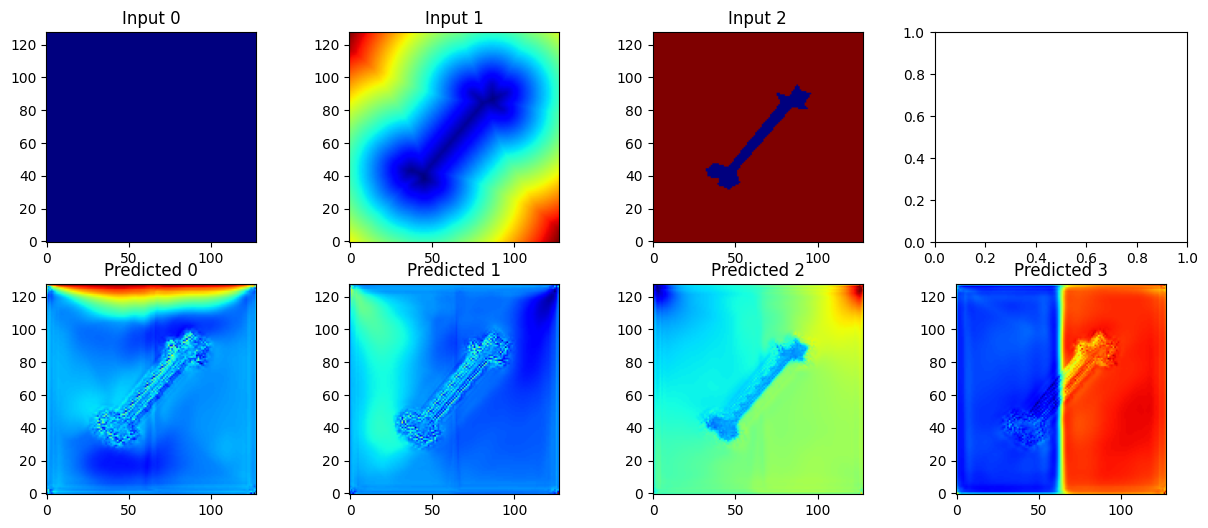

In [24]:
model.eval()
sample_idx = 0
x_sample = torch.from_numpy(X[sample_idx:sample_idx+1]).to(device)
y_true = Y[sample_idx]
with torch.no_grad():
    y_pred = model(x_sample).cpu().numpy()[0]

# Plot
fig, axes = plt.subplots(2, max(X.shape[1], Y.shape[1]), figsize=(15,6))
for i in range(X.shape[1]):
    axes[0,i].imshow(X[sample_idx,i], origin='lower', cmap='jet')
    axes[0,i].set_title(f"Input {i}")
for i in range(Y.shape[1]):
    axes[1,i].imshow(y_pred[i], origin='lower', cmap='jet')
    axes[1,i].set_title(f"Predicted {i}")
plt.show()


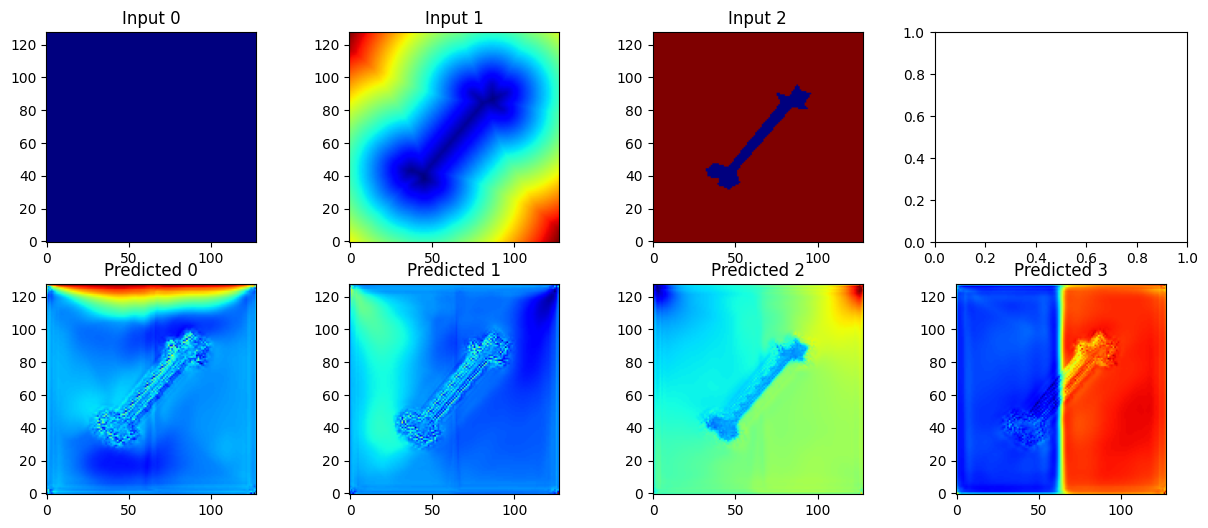

In [25]:
model.eval()
sample_idx = 0
x_sample = torch.from_numpy(X[sample_idx:sample_idx+1]).to(device)
y_true = Y[sample_idx]
with torch.no_grad():
    y_pred = model(x_sample).cpu().numpy()[0]

# Plot
fig, axes = plt.subplots(2, max(X.shape[1], Y.shape[1]), figsize=(15,6))
for i in range(X.shape[1]):
    axes[0,i].imshow(X[sample_idx,i], origin='lower', cmap='jet')
    axes[0,i].set_title(f"Input {i}")
for i in range(Y.shape[1]):
    axes[1,i].imshow(y_pred[i], origin='lower', cmap='jet')
    axes[1,i].set_title(f"Predicted {i}")
plt.show()

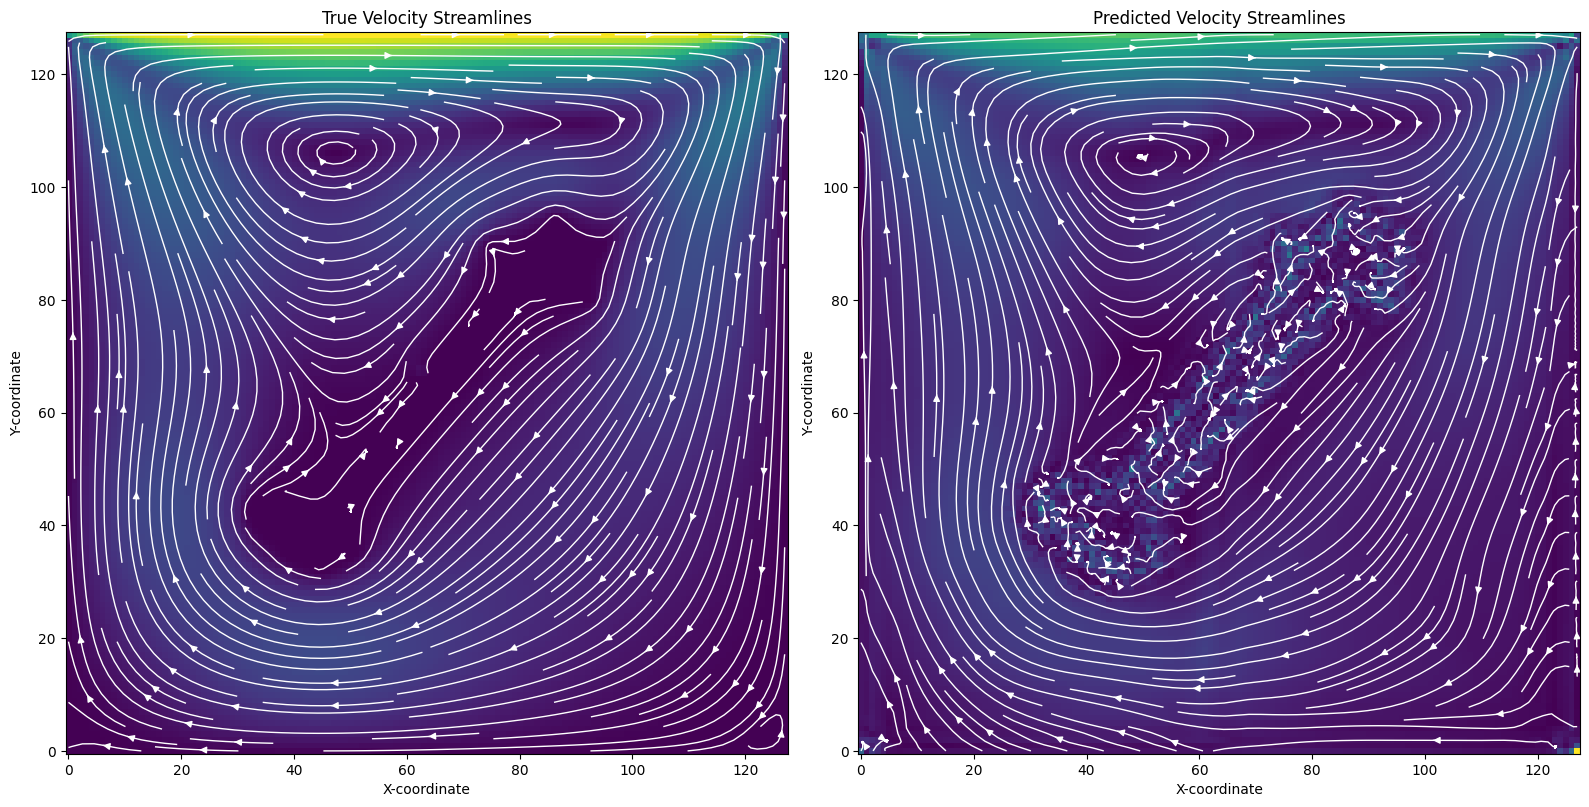

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming sample_idx is already defined from previous execution (e.g., sample_idx = 0)
# Extract true u and v components (assuming 0th and 1st channels)
true_u = Y[sample_idx, 0]
true_v = Y[sample_idx, 1]

# Extract predicted u and v components (assuming 0th and 1st channels from y_pred)
# y_pred is already calculated in the previous cell
pred_u = y_pred[0]
pred_v = y_pred[1]

# Create a grid for the streamplot
H, W = true_u.shape
X_grid, Y_grid = np.meshgrid(np.arange(W), np.arange(H))

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot True Streamlines
axs[0].imshow(np.sqrt(true_u**2 + true_v**2), cmap='viridis', origin='lower') # Background for magnitude
axs[0].streamplot(X_grid, Y_grid, true_u, true_v, color='white', density=2, linewidth=1)
axs[0].set_title('True Velocity Streamlines')
axs[0].set_xlabel('X-coordinate')
axs[0].set_ylabel('Y-coordinate')

# Plot Predicted Streamlines
axs[1].imshow(np.sqrt(pred_u**2 + pred_v**2), cmap='viridis', origin='lower') # Background for magnitude
axs[1].streamplot(X_grid, Y_grid, pred_u, pred_v, color='white', density=2, linewidth=1)
axs[1].set_title('Predicted Velocity Streamlines')
axs[1].set_xlabel('X-coordinate')
axs[1].set_ylabel('Y-coordinate')

plt.tight_layout()
plt.show()

This plot compares the true velocity streamlines with the predicted ones. The background color represents the velocity magnitude, and the white lines indicate the flow direction. This helps in visually assessing how well the model captures the fluid flow patterns.